In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband

In [2]:
### Integrating with period determination
library=pd.read_csv('simcodes/ZTF_VS_all_formatted.csv',index_col=0)
library['unique_filts_']=library['unique_filts_'].apply(lambda x:list(map(eval,x[1:-1].split(' '))))
library['ymean_by_filt_']=library['ymean_by_filt_'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))
library['theta']=library['theta'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))

In [139]:
def determinePeriod(row,missingData:bool=True,numPoints=60,frac:float=0.3,plot:bool=True)->float:
    """
    Determine period for a simulated light curve 'observed' with a given cadence. Credits for the simcode and 
    LCs to Kresimir Tisanic
    """
    tt=[]
    p=row['_best_period']
    tt.append(np.linspace(0,p*5,numPoints))
    
    if missingData==True:
        rem=(tt[0]%p)/p
        i=0
        while i<=round(1-frac,2):
            t=np.delete(tt[0],(rem>i) & (rem<(i+frac)))
            i+=0.1
            tt.append(t)
    periodMin=p*0.1
    periodMax=p*2.1
    pp={}
    if plot==True:
        fig=plt.figure(figsize=(5,5))
        subplot=fig.add_subplot(1,1,1)
    for i,t in enumerate(tt):
        filts=[row['unique_filts_'][0]]*len(t)
        ext=ExtendedLS(fit_period=True,optimizer_kwds=dict(quiet=True),Nterms_base=row['Nterms'])
        ext.import_parameters(row)
        mags = ext.predict(t=t,filts=filts)
        magErrs=0.1*mags
        ext.optimizer.period_range = (periodMin, periodMax)
        p=ext.fit(t,mags,magErrs,filts).best_period
        if plot==True:
            subplot.scatter((t%p)/p,mags,s=1,label=str(i))
        pp['detectedPeriod_'+str(i)]=p
        pp['phase_'+str(i)]=(t%p)/p
        pp['mags_'+str(i)]=mags
    if plot==True:
        plt.legend()
    return pp

In [140]:
libraryShort=library.iloc[0:3]

In [150]:
outputs={}
summary=pd.DataFrame(columns=['numPoints','frac','maxAbsDiff','stdDiff'])
for numPoints in range(30,41,5):
    perDetermine={}
    print(numPoints,': ',end='')
    for frac in np.linspace(0.3,0.8,6):
        frac=round(frac,1)
        print(frac,end=' ')
        libraryOutput=libraryShort.apply(lambda row:determinePeriod(row,frac=frac,
                                                           plot=False,
                                                           numPoints=numPoints), 
                                                           axis=1, result_type='expand')
        workCols=[c for c in libraryOutput.columns if 'detectedPeriod' in c]
        libraryOutput2=libraryOutput[workCols].div(libraryOutput['detectedPeriod_0'],axis=0)
        libraryOutput2=libraryOutput2.rename({c:c.replace('detectedPeriod','periodRatio') for c in libraryOutput2.columns},
                                             axis='columns')
        
        workCols=[c for c in libraryOutput.columns if 'periodRatio' in c]
        libraryOutput2['maxRatio']=libraryOutput2[workCols].abs().max(axis='columns',skipna=True)
        libraryOutput2['minRatio']=libraryOutput2[workCols].abs().min(axis='columns',skipna=True)
        libraryOutput2['std']=libraryOutput2[workCols].std(axis='columns',skipna=True)
        for c in libraryOutput.columns: 
            if 'phase' or 'mags' in c:
                libraryOutput2[c]=libraryOutput[c]
        
        perDetermine[frac]=libraryOutput2
        rec={'numPoints':numPoints,'frac':frac,
             'maxRatio':round(libraryOutput2['maxRatio'].max(),4),
             'minRatio':round(libraryOutput2['minRatio'].min(),4),
             'stdDiff':round(libraryOutput2['std'].max(),4)}
        summary=summary.append(rec,ignore_index=True)
    print('')
    outputs[numPoints]=perDetermine

30 : 0.3 0.4 0.5 0.6 0.7 0.8 
35 : 0.3 0.4 0.5 0.6 0.7 0.8 
40 : 0.3 0.4 0.5 0.6 0.7 0.8 


In [151]:
test=outputs[40][0.3]

In [153]:
workCols=[c for c in test.columns if 'periodRatio' in c]
test[workCols].abs().max(axis='columns',skipna=True)

0    6.799575
1    6.800041
2    6.798895
dtype: float64

In [156]:
test

,periodRatio_0,periodRatio_1,periodRatio_2,periodRatio_3,periodRatio_4,periodRatio_5,periodRatio_6,periodRatio_7,periodRatio_8,maxRatio,...,mags_5,detectedPeriod_6,phase_6,mags_6,detectedPeriod_7,phase_7,mags_7,detectedPeriod_8,phase_8,mags_8
0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,6.799575,NaN,...,"[21.58546729, 21.713365728119854, 21.705166264...",0.034811,"[0.0, 0.8718192918192921, 0.7436385836385843, ...","[21.58546729, 21.713365728119854, 21.705166264...",0.034811,"[0.0, 0.8718192918192921, 0.7436385836385843, ...","[21.58546729, 21.713365728119854, 21.705166264...",0.236698,"[0.0, 0.12821672771672774, 0.25643345543345547...","[21.58546729, 21.713365728119854, 21.705166264..."
1,1.0,6.800041,1.0,1.0,1.0,1.0,1.0,1.000000,6.798895,NaN,...,"[19.57791128, 19.43939095713814, 19.3706853590...",16.670372,"[0.0, 0.8718192918192922, 0.7436385836385843, ...","[19.57791128, 19.43939095713814, 19.3706853590...",16.670372,"[0.0, 0.8718192918192922, 0.7436385836385843, ...","[19.57791128, 19.43939095713814, 19.3706853590...",113.340117,"[0.0, 0.12822954822954824, 0.2564590964590965,...","[19.57791128, 19.43939095713814, 19.3706853590..."
2,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.772732,6.798895,NaN,...,"[19.31244542, 19.2233348204508, 19.31253353123...",10.361732,"[0.0, 0.8718192918192915, 0.743638583638583, 0...","[19.31244542, 19.2233348204508, 19.31253353123...",8.006844,"[0.0, 0.12822954822954774, 0.2564590964590955,...","[19.31244542, 19.2233348204508, 19.31253353123...",70.448329,"[0.0, 0.1282295482295482, 0.2564590964590964, ...","[19.31244542, 19.2233348204508, 19.31253353123..."


In [127]:
workCols=[c for c in test.columns if 'diffPeriod' in c]
test[workCols].div(test['diffPeriod_0'],axis=0)

,diffPeriod_0,diffPeriod_1,diffPeriod_2,diffPeriod_3,diffPeriod_4,diffPeriod_5,diffPeriod_6,diffPeriod_7,diffPeriod_8
0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,6.799575
1,1.0,6.800041,1.0,1.0,1.0,1.0,1.0,1.000000,6.798895
2,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.772732,6.798895


In [126]:
workCols=[c for c in test.columns if 'diffPeriod' in c]
test[workCols].sub(test['diffPeriod_0'],axis='index').div(test['diffPeriod_0'],axis=0)*100

,diffPeriod_0,diffPeriod_1,diffPeriod_2,diffPeriod_3,diffPeriod_4,diffPeriod_5,diffPeriod_6,diffPeriod_7,diffPeriod_8
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,579.957528
1,0.0,580.00405,0.0,0.0,0.0,0.0,0.0,0.000000,579.889545
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-22.726781,579.889545


In [106]:
outputs[30][0.3]

,diffPeriod_0,diffPeriod_1,diffPeriod_2,diffPeriod_3,diffPeriod_4,diffPeriod_5,diffPeriod_6,diffPeriod_7,diffPeriod_8,maxAbsDiff,...,phase_4,mags_4,phase_5,mags_5,phase_6,mags_6,phase_7,mags_7,phase_8,mags_8
0,0.049315,0.034811,0.049315,0.049315,0.049315,0.049315,0.034811,0.049315,0.049317,29.410941,...,"[0.0, 0.8276190476190478, 0.3104761904761914, ...","[21.58546729, 21.72763273673688, 21.2554999217...","[0.0, 0.8276190476190478, 0.6552380952380957, ...","[21.58546729, 21.72763273673688, 21.6191782937...","[0.0, 0.17244663382594452, 0.34489326765188905...","[21.58546729, 21.72763273673688, 21.6191782937...","[0.0, 0.8276190476190478, 0.6552380952380957, ...","[21.58546729, 21.72763273673688, 21.6191782937...","[0.0, 0.8275832877212191, 0.6551665754424383, ...","[21.58546729, 21.72763273673688, 21.6191782937..."
1,23.616085,23.616577,23.616085,16.670372,23.616085,23.616085,16.670372,23.616085,16.670372,29.410941,...,"[0.0, 0.8276190476190478, 0.3104761904761912, ...","[19.57791128, 19.404350120069534, 19.712335640...","[0.0, 0.8276190476190478, 0.6552380952380956, ...","[19.57791128, 19.404350120069534, 19.388824326...","[0.0, 0.1724466338259445, 0.344893267651889, 0...","[19.57791128, 19.404350120069534, 19.388824326...","[0.0, 0.8276190476190478, 0.6552380952380956, ...","[19.57791128, 19.404350120069534, 19.388824326...","[0.0, 0.1724466338259445, 0.344893267651889, 0...","[19.57791128, 19.404350120069534, 19.388824326..."
2,14.678948,10.361732,14.678948,14.678948,14.678948,14.678948,10.361732,14.678948,70.448329,379.927633,...,"[0.0, 0.8276190476190473, 0.310476190476189, 0...","[19.31244542, 19.234473144352695, 19.782243521...","[0.0, 0.8276190476190473, 0.6552380952380945, ...","[19.31244542, 19.234473144352695, 19.453136619...","[0.0, 0.17244663382594366, 0.3448932676518873,...","[19.31244542, 19.234473144352695, 19.453136619...","[0.0, 0.8276190476190473, 0.6552380952380945, ...","[19.31244542, 19.234473144352695, 19.453136619...","[0.0, 0.17244663382594413, 0.34489326765188827...","[19.31244542, 19.234473144352695, 19.453136619..."


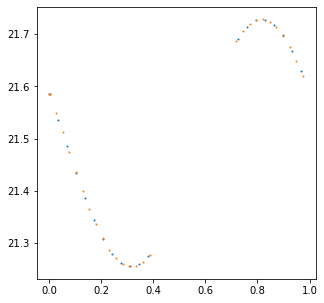

In [107]:
numPoints=30
frac=0.3
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(outputs[numPoints][frac].iloc[0]['phase_4'],outputs[numPoints][frac].iloc[0]['mags_4'],s=1)
ax.scatter(outputs[40][frac].iloc[0]['phase_4'],outputs[40][frac].iloc[0]['mags_4'],s=1)

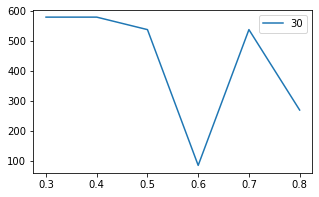

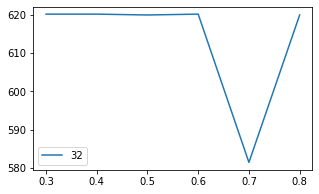

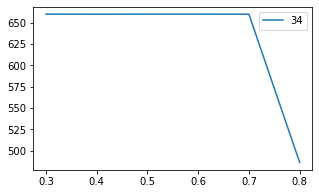

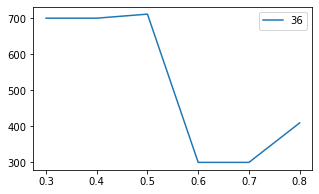

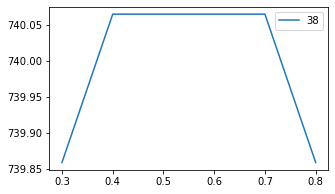

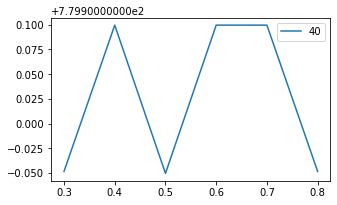

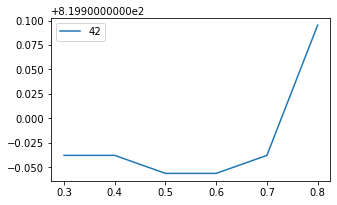

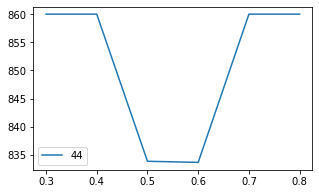

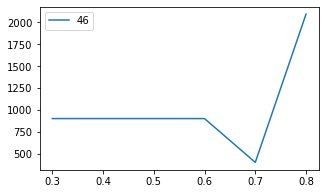

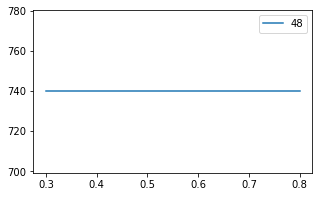

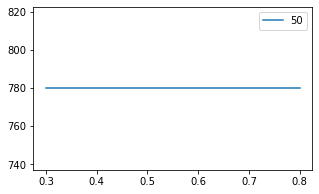

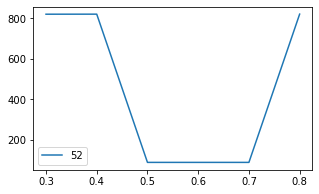

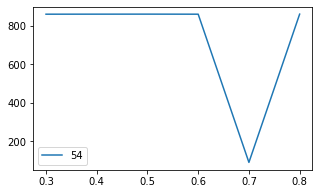

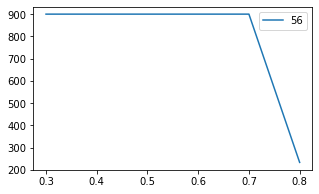

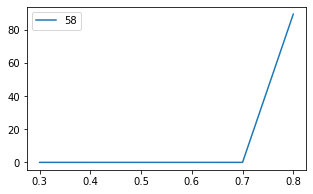

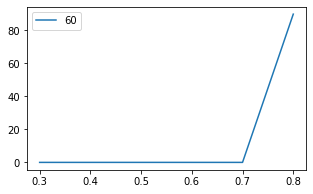

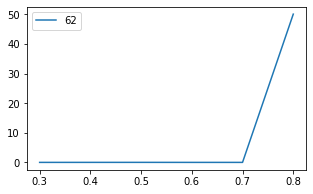

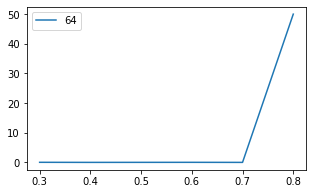

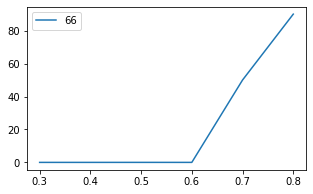

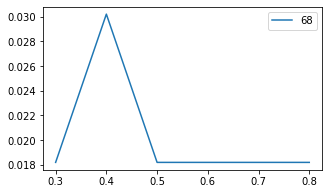

In [73]:
for numPoints in range(30,70,2):
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(summary[summary['numPoints']==numPoints]['frac'],
                summary[summary['numPoints']==numPoints]['maxAbsDiff'],label=str(numPoints))
    ax.legend()

In [76]:
outputs[0.6]

,detectedPeriod_0,detectedPeriod_1,detectedPeriod_2,detectedPeriod_3,detectedPeriod_4,detectedPeriod_5,maxAbsDiff,std
0,NaN,0.000000,0.000000,0.0,0.0,0.001379,0.001379,0.000617
1,NaN,0.018182,-0.018182,0.0,0.0,0.000000,0.018182,0.012856
2,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,NaN,0.000000,0.000000,0.0,0.0,0.001379,0.001379,0.000617
4,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
5,NaN,0.000000,0.000000,0.0,0.0,0.001379,0.001379,0.000617
6,NaN,0.018182,-0.018182,0.0,0.0,0.000000,0.018182,0.012856
7,NaN,0.000000,0.000000,0.0,0.0,0.001379,0.001379,0.000617
8,NaN,0.018182,-0.018182,0.0,0.0,0.000000,0.018182,0.012856
9,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [77]:
import ipywidgets as widgets
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider(value=7, continuous_update=False, description='Test:', max=10)

In [79]:
tab_contents = ['numPoints', 'Fraction of absent']
children = [widgets.Text(description=name) for name in tab_contents]
children[3]=widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
tab = widgets.Tab()
tab.children = children
for ii in range(len(children)):
    tab.set_title(ii, f"tab_{ii}")
tab

In [83]:
out1 = widgets.Output()
out2 = widgets.Output()
data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'numPoints')
tab.set_title(1, 'fraction of absent')
display(tab)

with out1:
    fig1, axes1 = plt.subplots()
    data1.hist(ax = axes1)
    
    widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
    plt.show(fig1)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)